In [1]:
import warnings
warnings.simplefilter(action='ignore')

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import numpy as np

In [2]:
df = pd.read_csv('Train_music_ForestImputer.csv')

In [3]:
X = df.drop(['target', 'id'], axis=1)
y = df['target']

In [4]:
selector_50 = SelectKBest(f_classif, k=50)
selector_100 = SelectKBest(f_classif, k=100)
selector_50.fit(X, y)
selector_100.fit(X, y)
# Get columns to keep and create new dataframe with those only
cols_50 = selector_50.get_support(indices=True)
cols_100 = selector_100.get_support(indices=True)
df_new_50 = X.iloc[:,cols_50]
df_new_100 = X.iloc[:,cols_100]

In [5]:
df_new_50['target'] = y
df_new_100['target'] = y

In [6]:
X_50, y_50 = df_new_50.drop(['target'], axis=1), df_new_50['target']
X_100, y_100 = df_new_100.drop(['target'], axis=1), df_new_100['target']

# Logistic Regression

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_sc = scaler.fit_transform(X_100)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
X_train, X_valid, y_train, y_valid = train_test_split(X_sc, y_100, test_size=0.25, random_state=42)

In [9]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_valid)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_valid, y_pred))

0.9276


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_valid, y_pred)
print(cm)

[[4626   23]
 [ 339   12]]


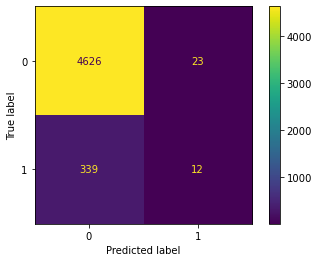

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
print('Precision:', precision_score(y_valid, y_pred))
print('Recall:', recall_score(y_valid, y_pred))
print('F1 score:', f1_score(y_valid, y_pred))
print('ROC AUC score:', roc_auc_score(y_valid, y_pred))

Precision: 0.34285714285714286
Recall: 0.03418803418803419
F1 score: 0.06217616580310882
ROC AUC score: 0.5146203668466521


# Настройка гиперпараметров логистической регрессии по f1_score

## Регуляризация L2

In [37]:
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(solver='liblinear')

C_values = {'C': np.logspace(-3, 3, 20)}
logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
logreg_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])},
             scoring='f1')

In [38]:
print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 26.366508987303554}
0.07803019775330772


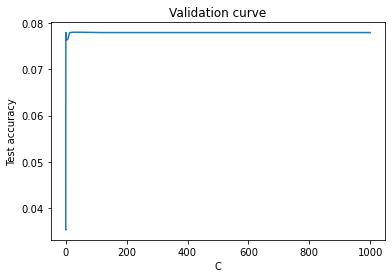

In [39]:
results_df = pd.DataFrame(logreg_grid.cv_results_)
plt.plot(results_df['param_C'], results_df['mean_test_score'])

# Подписываем оси и график
plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

In [40]:
y_pred = logreg_grid.best_estimator_.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[4626   23]
 [ 339   12]]
F1 score valid: 0.06217616580310882


## Регуляризация L1

In [41]:
log_reg = LogisticRegression(solver='liblinear', penalty='l1')

C_values = {'C': np.logspace(-3, 3, 20)}
logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
logreg_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])},
             scoring='f1')

In [42]:
print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 54.555947811685144}
0.07803019775330772


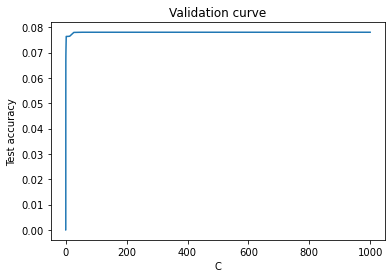

In [43]:
results_df = pd.DataFrame(logreg_grid.cv_results_)
plt.plot(results_df['param_C'], results_df['mean_test_score'])

# Подписываем оси и график
plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

In [44]:
y_pred = logreg_grid.best_estimator_.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[4626   23]
 [ 339   12]]
F1 score valid: 0.06217616580310882
